# References

- <https://doi.org/10.1109/ACCESS.2018.2866538>
- <https://www.kaggle.com/datasets/joebeachcapital/land-mines>
- <https://www.kaggle.com/datasets/ritwikb3/land-mines-detection>

# Dataset Explanation

The data are already normalized (all values are between `0` and `1`).

- `V` - Voltage. Output voltage value of FLC sensor due to magnetic distortion
- `H` - Height. The height of the sensor from the ground.
- `S` - Soil. Six different soil types depending on the moisture condition.
  * `1` = Dry and Sandy
  * `2` = Dry and Humus
  * `3` = Dry and Limy
  * `4` = Humid and Sandy
  * `5` = Humid and Humus
  * `6` = Humid and Limy
- `M` - Mine type. Mine types commonly encountered on land. Five different mine classes.
  * `1` = (Null): 71
  * `2` = (Anti-tank):70
  * `3` = (Anti-personnel):66
  * `4` = (Booby Trapped Anti-personnel):66
  * `5` = (M14 Anti-personnel):65

For this problem, only two mine labels are used: `0` for no mine, and `1` for a mine of any type.

# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

BASE_DIR = os.path.abspath("")
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
ORIG_DATA_FILE = os.path.join(DATA_DIR, "landmines.csv")
CLEANED_DATA_FILE = os.path.join(DATA_DIR, "landmines-cleaned.csv")
RESAMPLED_DATA_FILE = os.path.join(DATA_DIR, "landmines-resampled.csv")
TRAIN_DATA_FILE = os.path.join(DATA_DIR, "landmines-train.csv")
TEST_DATA_FILE = os.path.join(DATA_DIR, "landmines-test.csv")

# Data Analysis

## Loading

In [2]:
df = pd.read_csv(ORIG_DATA_FILE)
df = df.rename(columns={
    "V": "voltage",
    "H": "height",
    "S": "soil_type",
    "M": "mine_type"
})
df.head()

,voltage,height,soil_type,mine_type
0,0.338157,0.000000,1,1
1,0.320241,0.181818,1,1
2,0.287009,0.272727,1,1
3,0.256284,0.454545,1,1
4,0.262840,0.545455,1,1


## Binary Column

In [3]:
df["is_mine"] = (df["mine_type"] > 1).astype("int")
df.head()

,voltage,height,soil_type,mine_type,is_mine
0,0.338157,0.000000,1,1,0
1,0.320241,0.181818,1,1,0
2,0.287009,0.272727,1,1,0
3,0.256284,0.454545,1,1,0
4,0.262840,0.545455,1,1,0


## Saving and Loading

In [4]:
df.to_csv(CLEANED_DATA_FILE, index=False)

In [5]:
df = pd.read_csv(CLEANED_DATA_FILE)

## Basic Analysis

In [6]:
df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
voltage,338.0,0.43,0.20,0.2,0.31,0.36,0.48,1.0
height,338.0,0.51,0.31,0.0,0.27,0.55,0.73,1.0
soil_type,338.0,3.52,1.72,1.0,2.00,4.00,5.00,6.0
mine_type,338.0,2.95,1.42,1.0,2.00,3.00,4.00,5.0
is_mine,338.0,0.79,0.41,0.0,1.00,1.00,1.00,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voltage    338 non-null    float64
 1   height     338 non-null    float64
 2   soil_type  338 non-null    int64  
 3   mine_type  338 non-null    int64  
 4   is_mine    338 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 13.3 KB


## Missing Values

In [8]:
df.isna().sum()

voltage      0
height       0
soil_type    0
mine_type    0
is_mine      0
dtype: int64

## Plots

### Single

<Axes: xlabel='voltage', ylabel='Percent'>

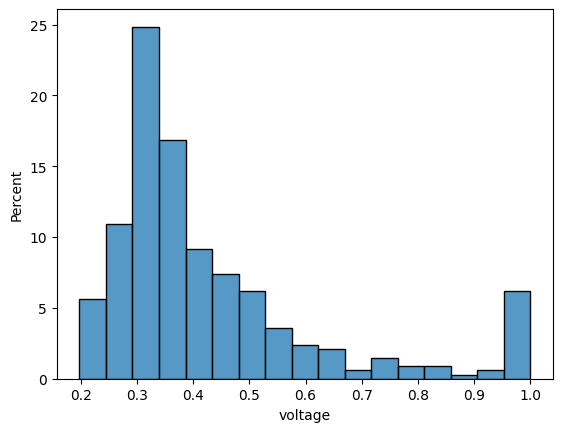

In [9]:
sns.histplot(data=df, x="voltage", stat="percent")

<Axes: xlabel='height', ylabel='Percent'>

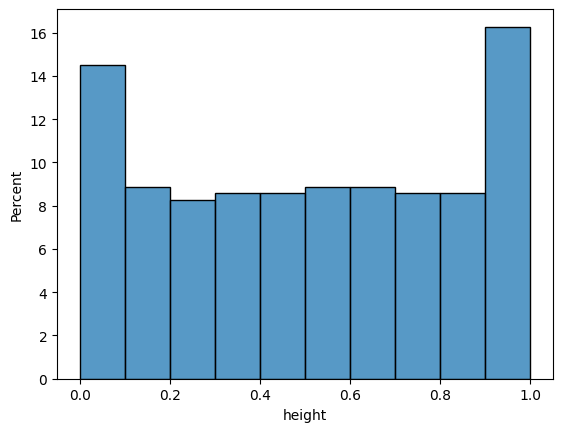

In [10]:
sns.histplot(data=df, x="height", stat="percent")

<Axes: xlabel='soil_type', ylabel='percent'>

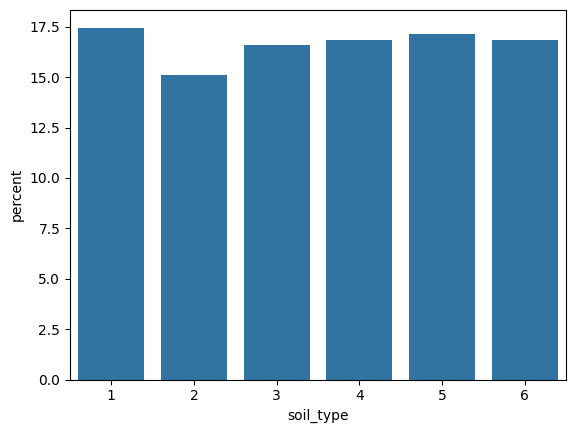

In [11]:
sns.countplot(data=df, x="soil_type", stat="percent")

<Axes: xlabel='mine_type', ylabel='percent'>

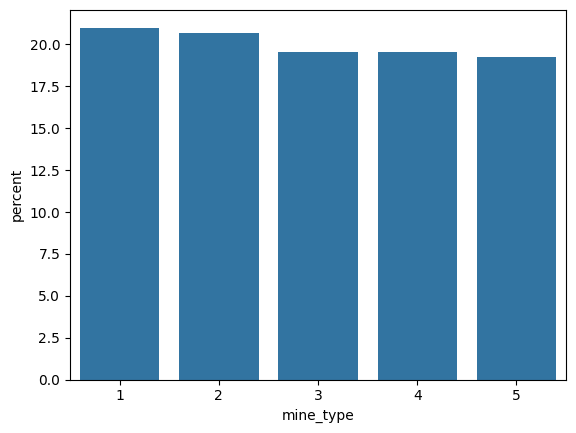

In [12]:
sns.countplot(data=df, x="mine_type", stat="percent")

Text(0.5, 1.0, 'is_mine')

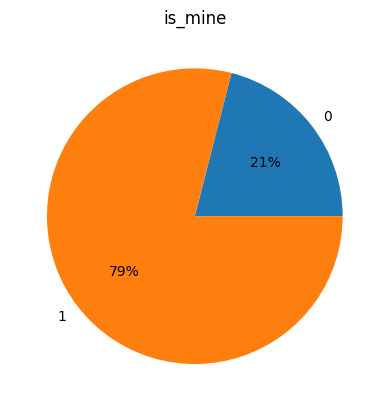

In [13]:
df.groupby("is_mine").size().plot.pie(autopct="%1.0f%%").set_title("is_mine")

### Double

<Axes: xlabel='is_mine', ylabel='voltage'>

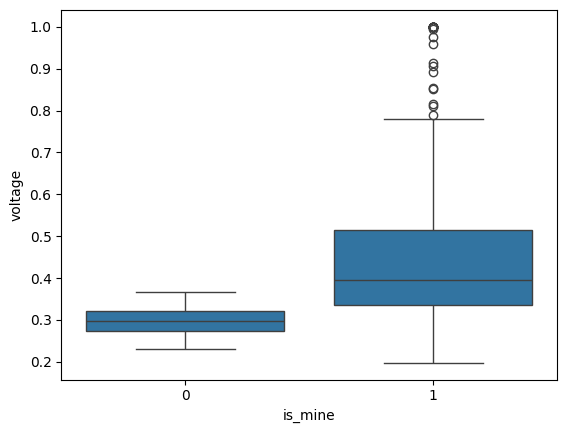

In [14]:
sns.boxplot(data=df, x="is_mine", y="voltage")

<Axes: xlabel='is_mine', ylabel='height'>

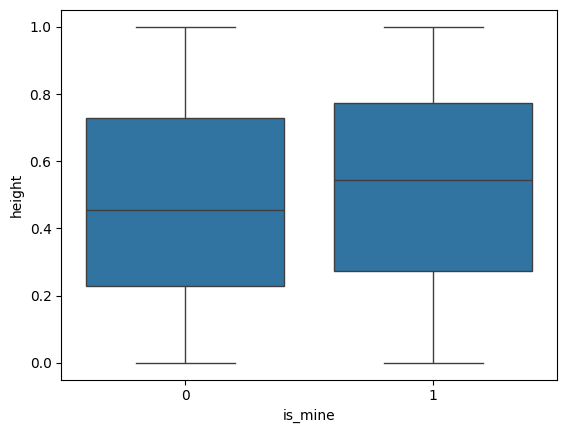

In [15]:
sns.boxplot(data=df, x="is_mine", y="height")

<Axes: xlabel='soil_type', ylabel='percent'>

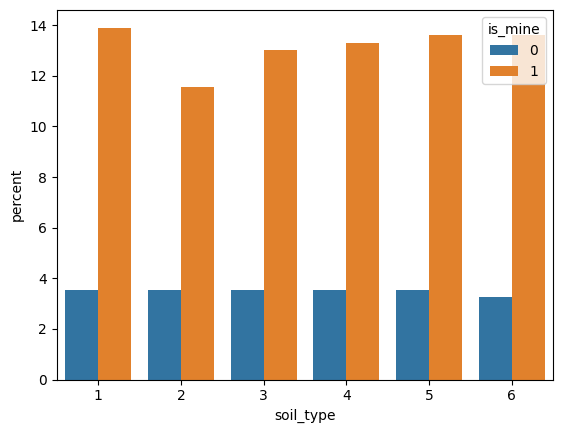

In [16]:
sns.countplot(data=df, x="soil_type", hue="is_mine", stat="percent")

<Axes: >

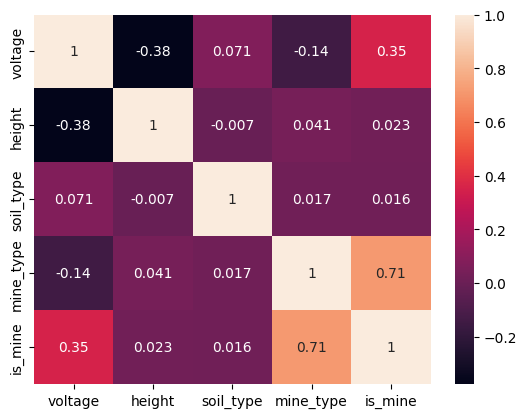

In [17]:
sns.heatmap(df.corr(), annot=True)

## Conclusions

The dataset is not balanced since there are more mines than non-mines. The dataset should be balanced so that thei number is equal. For that purpose, `RandomOverSampler` is used.

Also, there is some correlation between voltage and the presence of a landmine as well as voltage and height.

# Data Preparation

## Loading

In [18]:
df = pd.read_csv(CLEANED_DATA_FILE)
df.head()

,voltage,height,soil_type,mine_type,is_mine
0,0.338157,0.000000,1,1,0
1,0.320241,0.181818,1,1,0
2,0.287009,0.272727,1,1,0
3,0.256284,0.454545,1,1,0
4,0.262840,0.545455,1,1,0


## Scaling

In [19]:
scaler = MinMaxScaler()
df["soil_type"] = scaler.fit_transform(df[["soil_type"]])

## Feature Selection

In [20]:
x = df.drop(columns=["mine_type", "is_mine"]).values
y = df[["is_mine"]].values

## Oversampling

In [21]:
ros = RandomOverSampler()
x_resampled, y_resampled = ros.fit_resample(x, y)

In [22]:
len(x)

338

In [23]:
len(x_resampled)

534

## Saving

In [24]:
df_resampled = pd.DataFrame(columns=["voltage", "height", "soil_type"], data=x_resampled)
df_resampled["is_mine"] = y_resampled

In [25]:
df_resampled.to_csv(RESAMPLED_DATA_FILE, index=False)

## Train-Test Split

In [26]:
df = pd.read_csv(RESAMPLED_DATA_FILE)

In [27]:
x = df.drop(columns=["is_mine"]).values
y = df[["is_mine"]].values

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

In [29]:
x_train

array([[0.33534705, 0.27272727, 0.6       ],
       [0.30211447, 0.90909091, 1.        ],
       [0.35368536, 0.72727273, 0.8       ],
       ...,
       [0.33534705, 0.18181818, 0.6       ],
       [0.3383682 , 0.09090909, 0.4       ],
       [0.53474256, 0.27272727, 0.6       ]])

In [30]:
y_train

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

## Saving

In [31]:
x_columns = ["voltage", "height", "soil_type"]

df_train = pd.DataFrame(columns=x_columns, data=x_train)
df_train["is_mine"] = y_train

df_test = pd.DataFrame(columns=x_columns, data=x_test)
df_test["is_mine"] = y_test

In [32]:
df_train.to_csv(TRAIN_DATA_FILE, index=False)
df_test.to_csv(TEST_DATA_FILE, index=False)

## Checking the Oversampling

Text(0.5, 1.0, 'is_mine')

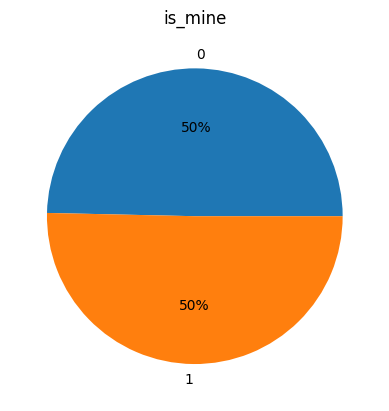

In [33]:
df_train.groupby("is_mine").size().plot.pie(autopct="%1.0f%%").set_title("is_mine")